In [1]:
#!pip install statsmodels

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Time Series

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error


# 4. PERFORM TIME SERIES FORECASTING

## 4.3 BUILD ARIMA FORECAST MODEL


In this task, you are required to build a Seasonal ARIMA model on the bikesharing.csv dataset. The model should be able to capture historical data and predict future daily bike rental.
In order to verify the model accuracy, you should use data from 2011-01-01 to 2012-10-31 as your training data, and data from 2012-11-01 to 2012-12-31 as testing data.
Remember to check for stationarity first! (Exercise.)
We can use SARIMA model (ARIMA with seasonality), your model output should look similar to below:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX

In [ ]:
# load the dataset
#df = pd.read_csv('data/bikesharing.csv')
df = pd.read_csv(
    './dataset/bikesharing.csv')

df['dteday'] = pd.to_datetime(df['dteday'])
df.set_index('dteday', inplace=True)
# group and calculate daily rental
daily_rental = df.resample('D')[['cnt']].sum()
# define training dataset
train_data = daily_rental[daily_rental.index<'2012-11']
test_data = daily_rental[daily_rental.index>='2012-11']

It includes:

* Decomposition to analyze trend and seasonality.
* ACF & PACF plots to determine SARIMA parameters (p, d, q) and (P, D, Q, S).
* Building and training the SARIMA model.
* Forecasting and evaluating using MAPE (Mean Absolute Percentage Error).
* Plotting train, test, and forecast results.

https://otexts.com/fpp3/classical-decomposition.html

Classical decomposition
These are described below for a time series with seasonal period m (e.g.,m=4 for quarterly data, m=12 for monthly data, m=7 for daily data with a weekly pattern).

In classical decomposition, we assume that the seasonal component is constant from year to year. For multiplicative seasonality, the  
m values that form the seasonal component are sometimes called the “seasonal indices”.




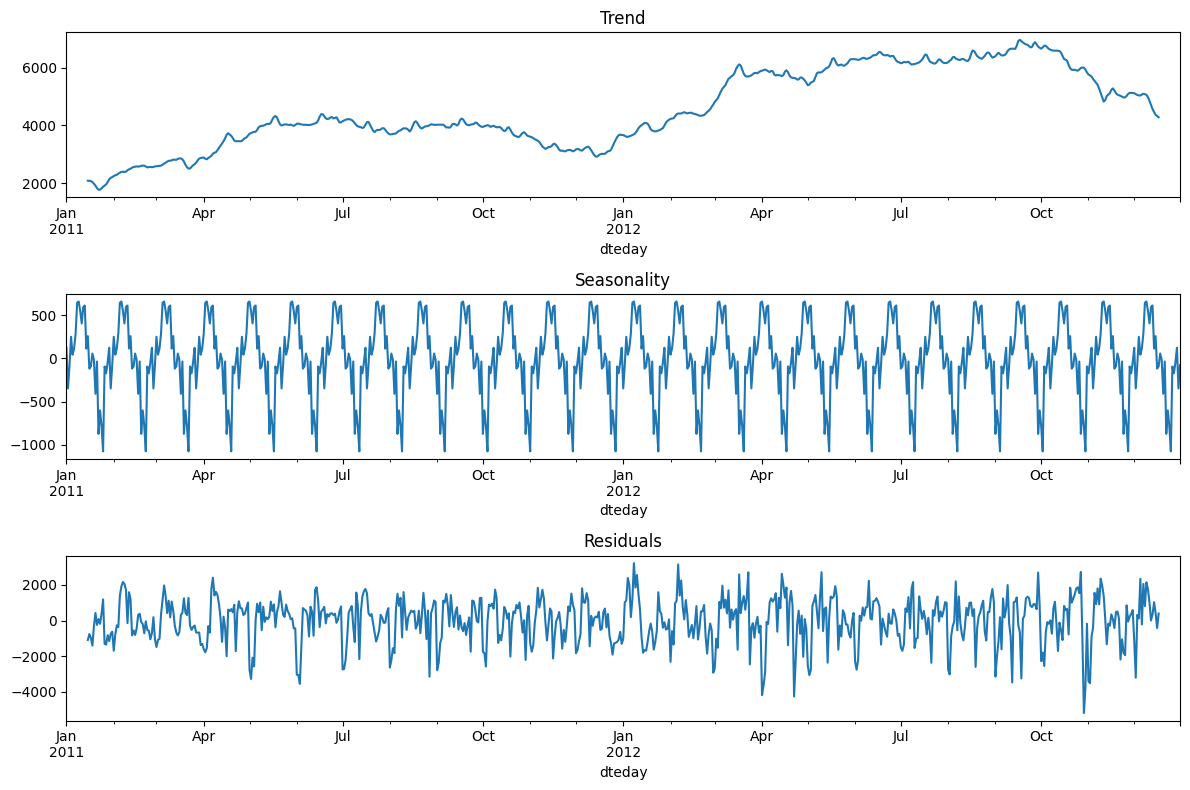

In [ ]:
# Decompose the time series to check trend and seasonality
decomposition = seasonal_decompose(daily_rental['cnt'], model='additive', period=28)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=ax1, title='Trend')
decomposition.seasonal.plot(ax=ax2, title='Seasonality')
decomposition.resid.plot(ax=ax3, title='Residuals')
plt.tight_layout()
plt.show()

https://otexts.com/fpp3/stationarity.html
## Stationarity and differencing

In [ ]:
# ADF Test for stationarity
def adf_test(series, name="Data"):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  P-value: {result[1]:.4f}")
    print(f"  Critical Values: {result[4]}")
    print("  Stationary" if result[1] < 0.05 else "  Not Stationary")

# Check stationarity of original data
adf_test(daily_rental['cnt'], "Original Data")

# Apply differencing if needed
df_diff = daily_rental['cnt'].diff().dropna()
adf_test(df_diff, "1st Differenced Data")  # Checking for d

# Seasonal differencing (D)
df_seasonal_diff = daily_rental['cnt'].diff(28).dropna()
adf_test(df_seasonal_diff, "Seasonal Differenced Data (28)")  # Checking for D

# Seasonal + First Differencing
df_combined_diff = daily_rental['cnt'].diff().diff(28).dropna()
adf_test(df_combined_diff, "1st + Seasonal Differenced Data (28)")

ADF Test for Original Data:
  Test Statistic: -2.5891
  P-value: 0.0953
  Critical Values: {'1%': -3.439580754053961, '5%': -2.865613606467485, '10%': -2.568939269723711}
  Not Stationary
ADF Test for 1st Differenced Data:
  Test Statistic: -10.1757
  P-value: 0.0000
  Critical Values: {'1%': -3.439593802573824, '5%': -2.865619356068967, '10%': -2.568942332870462}
  Stationary
ADF Test for Seasonal Differenced Data (28):
  Test Statistic: -3.6954
  P-value: 0.0042
  Critical Values: {'1%': -3.439974756130998, '5%': -2.865787205712192, '10%': -2.569031757724822}
  Stationary
ADF Test for 1st + Seasonal Differenced Data (28):
  Test Statistic: -11.1278
  P-value: 0.0000
  Critical Values: {'1%': -3.439974756130998, '5%': -2.865787205712192, '10%': -2.569031757724822}
  Stationary


Using ACF and PACF plots

AR
https://otexts.com/fpp3/AR.html

MA
https://otexts.com/fpp3/MA.html

ARIMA
https://otexts.com/fpp3/non-seasonal-arima.html

SARIMA
https://otexts.com/fpp3/seasonal-arima.html



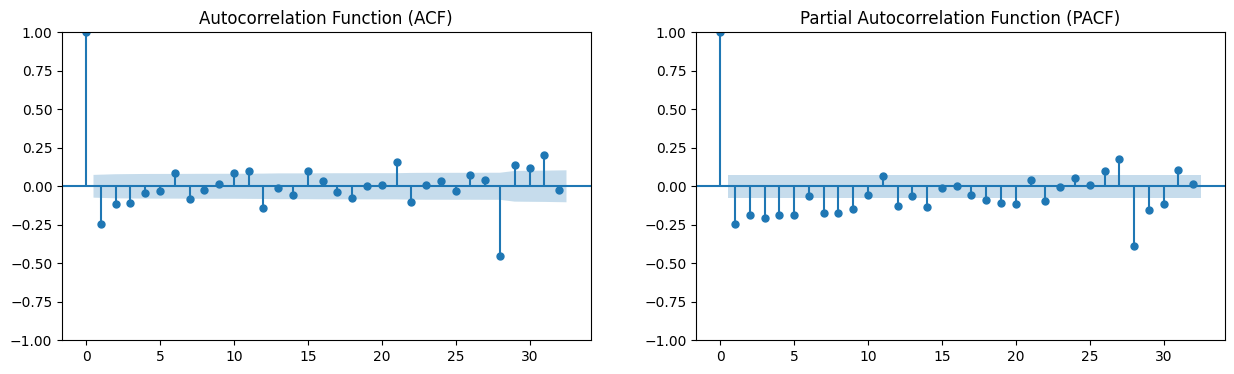

In [ ]:
# ACF and PACF plots to determine (p, d, q) and (P, D, Q, S)
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_combined_diff.dropna(), lags=32, ax=axes[0])
plot_pacf(df_combined_diff.dropna(), lags=32, ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

https://otexts.com/fpp3/arima-estimation.html

For ARIMA models, the corrected AIC can be written as
AICc and the Bayesian Information Criterion can be written as
BIC. Good models are obtained by minimising the AIC, AICc or BIC. Our preference is to use the AICc.


**Auto ARIMA**

https://alkaline-ml.com/pmdarima/about.html#how-it-works


The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

https://alkaline-ml.com/pmdarima/tips_and_tricks.html


In [ ]:
# Set SARIMA order based on observations (adjust manually if needed)
p, d, q = 3, 1, 0  # Adjust based on PACF & ACF plots
P, D, Q, S = 1, 1, 1, 28  # Seasonal components with weekly seasonality

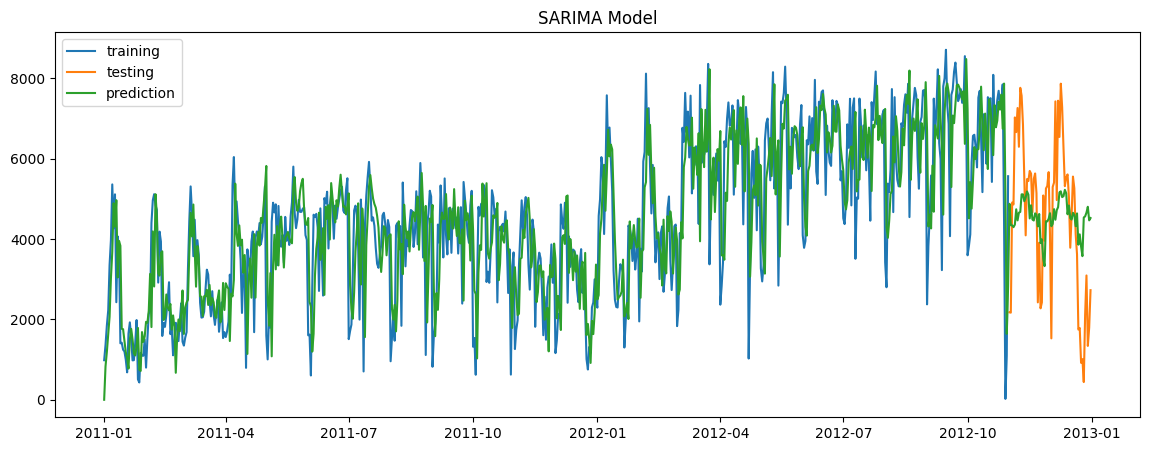

In [ ]:
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

# Get the forecast/pred
pred = sarima_model.get_prediction(start='2011-01-01', end='2012-12-31').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [ ]:
# To evaluate the model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train_data, pred[pred.index<'2012-11'])
mape_test = mean_absolute_percentage_error(test_data, pred[pred.index>='2012-11'])
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 65.86%
Model Mean Absolute Percentage Error on testing data is 63.14%
